In [1]:
import sys

module_path = "../packages"
if module_path not in sys.path:
    sys.path.append(module_path)


import math
import os
import random
import sys

import matplotlib
import matplotlib.pyplot as plt
import mrcnn.model as modellib
import numpy as np
import skimage.io
from mrcnn import utils, visualize

import coco
import parameters
import cv2

from utils import *


# Directory to save logs and trained model
MODEL_DIR = os.path.join(parameters.RESULTS_PATH, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(parameters.MODEL_PATH, "mask_rcnn_coco.h5")


class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

2021-07-10 03:01:43.945114: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'r

# Car Segmentation on image

/media/disk_cris/TRABAJOS/PROYECTOS/Park/env37park/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2021-07-10 03:02:17.966041: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-07-10 03:02:18.308332: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8200
2021-07-10 03:02:18.816987: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-10 03:02:19.192589: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


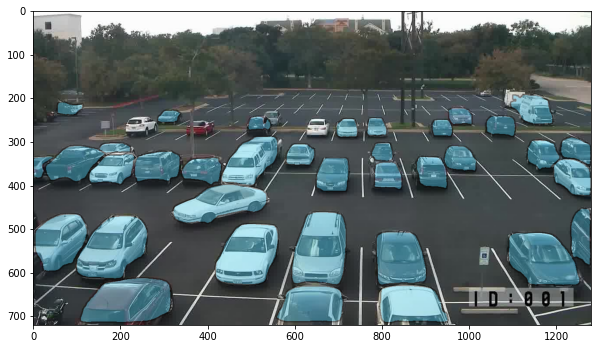

In [2]:
bgr_image = cv2.imread(parameters.DATA_PATH+'espacio-libre.jpg')
rgb_image = cv2.cvtColor(bgr_image,cv2.COLOR_BGR2RGB)

car_points = get_car_points(rgb_image,model)

bgr_image = plot_cars(bgr_image,car_points,alpha=0.4)


cv2.imwrite(parameters.RESULTS_PATH+'car_image_segmentation.jpg', bgr_image)

rgb_image = cv2.cvtColor(bgr_image,cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()
#cv2.imshow('soel',bgr_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


# Car Segmentation on video

In [3]:
import cv2
import numpy as np

# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture(parameters.DATA_PATH+'stace_park3.mp4')

# Check if camera opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

# Read until video is completed
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  if ret == True:

    #frame = cv2.resize(frame,(300,300))
    # Display the resulting frame
    rgb_image = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    car_points = get_car_points(rgb_image,model)
            
    frame = plot_cars(frame,car_points,alpha=0.4)

    cv2.imshow('Frame',frame)

    # Press Q on keyboard to  exit
    if cv2.waitKey(20) & 0xFF == ord('q'):
      break

  # Break the loop
  else: 
    break

# When everything done, release the video capture object
cap.release()

# Closes all the frames
cv2.destroyAllWindows()